In [1]:
import xarray as xr
from datetime import datetime, timedelta
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import os
from netCDF4 import Dataset
from data.datasets import ERA5Dataset
from neuralop.utils import count_model_params
import h5py
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri.cm as cmc
import torch
from timeit import default_timer
from utils.losses import EnergyScore, KernelScore, VariogramScore, LpLoss
from models.fno import FNO
from models.uno import UNO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

In [2]:
batch_size = 8
n_samples = 10 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval

In [3]:
data_dir = "../data/era5/"
train_data = ERA5Dataset(data_dir, var="train")
val_data = ERA5Dataset(data_dir, var="val")

x,y,t = train_data.get_coordinates()
L = train_data.get_domain_range()

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

n_train = len(train_loader)
n_test = len(val_loader)

In [4]:
# Losses and parameters
l2loss = LpLoss(d=3, p=2, L = L)
energy_score = EnergyScore(d = 3, p = 2, type = "lp", L = L)

# Training parameters
epochs = 5
max_train = 500
max_val = 500
learning_rate = 0.001
dropout_rate = None

In [5]:
model = FNO(n_modes=(4,16, 16), hidden_channels=32, in_channels = 4,
                        dropout=dropout_rate, lifting_channels = 128,
                        projection_channels = 128)
model = model.to(device)

n_params = count_model_params(model)
print(f"\nOur model has {n_params} parameters.")
sys.stdout.flush()


Our model has 4731937 parameters.


In [6]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [7]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        optimizer.zero_grad()
        out = model(a)
        
        l2 = l2loss(out, u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

        if i >= max_train:
            break

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for i,sample in enumerate(val_loader):
            a, u = sample
            a = a.to(device)
            u = u.to(device)

            out = model(a)
            test_l2 += l2loss(out, u).item()

            if i >= max_val:
                break

    train_l2  = train_l2 * batch_size / max_train
    test_l2 = test_l2 * batch_size / max_val
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-301.4686, Train-L2-3.4266, Test-L2-0.9556
Epoch-1, Time-300.5913, Train-L2-2.5341, Test-L2-0.9095
Epoch-2, Time-300.6308, Train-L2-2.4333, Test-L2-0.8858
Epoch-3, Time-300.6334, Train-L2-2.3504, Test-L2-0.8867
Epoch-4, Time-300.5361, Train-L2-2.3123, Test-L2-0.8655


In [8]:
with torch.no_grad():
    for i,sample in enumerate(val_loader):
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        out = model(a)
        break

Text(0.5, 1.0, 'Prediction')

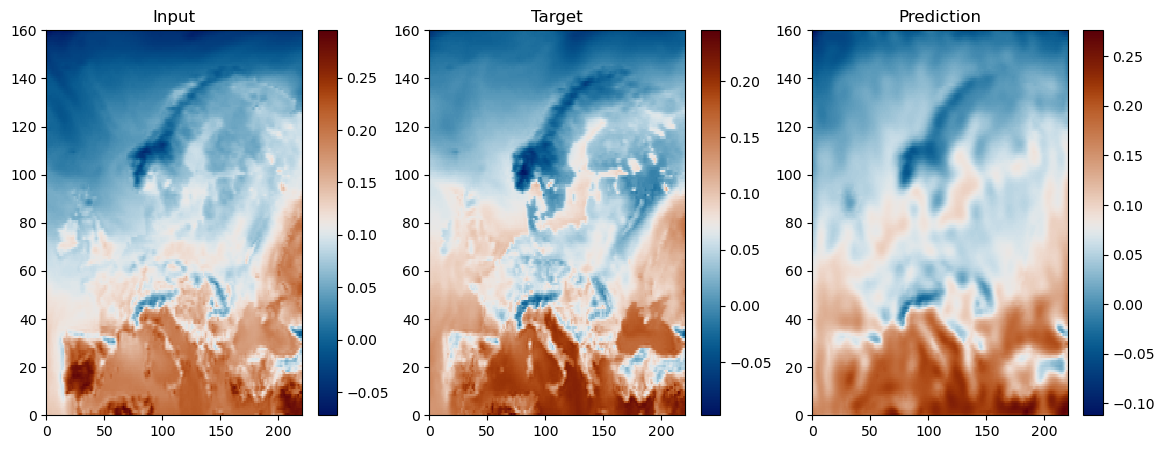

In [19]:
idx = 6
t = 4

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
im = axs[0].pcolormesh(a[idx,0,-1].cpu().numpy())
fig.colorbar(im, ax=axs[0])
axs[0].set_title("Input")
im2 = axs[1].pcolormesh(u[idx,0,t].cpu().numpy())
fig.colorbar(im2, ax=axs[1])
axs[1].set_title("Target")
im3 = axs[2].pcolormesh(out[idx,0,t].cpu().numpy())
fig.colorbar(im3, ax=axs[2])
axs[2].set_title("Prediction")